<a href="https://colab.research.google.com/github/AlfiRam/Face-to-BMI-with-ViT/blob/main/Face_to_BMI_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [ ]:
import tensorflow.keras.utils

In [ ]:
csv_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/data/data.csv"
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/data/Images"

csv_data = pd.read_csv(csv_path)

# Data Cleaning
Remove Columns that do not contain Image files

In [ ]:
def image_exists(row, image_folder):
    image_path = os.path.join(image_folder, row['name'])  # Replace 'image_column' with your actual column name
    return os.path.isfile(image_path)

# Create a new DataFrame with an additional column to check for image existence
data_with_existence = csv_data.copy()
data_with_existence['image_exists'] = csv_data.apply(image_exists, axis=1, image_folder=image_path)

# Filter out rows where the image does not exist and create a new DataFrame
data_cleaned = data_with_existence[data_with_existence['image_exists']]

# Optionally, drop the 'image_exists' column as it's no longer needed
data_cleaned = data_cleaned.drop(columns=['image_exists'])

In [ ]:
len(data_cleaned)

3962

In [ ]:
data_cleaned.head(10)

Unnamed: 0        bmi  gender  is_training        name
0            0  34.207396    Male            1   img_0.bmp
1            1  26.453720    Male            1   img_1.bmp
2            2  34.967561  Female            1   img_2.bmp
3            3  22.044766  Female            1   img_3.bmp
6            6  25.845588  Female            1   img_6.bmp
7            7  21.740701  Female            1   img_7.bmp
8            8  30.615858  Female            1   img_8.bmp
9            9  26.788876  Female            1   img_9.bmp
10          10  38.732782    Male            1  img_10.bmp
11          11  30.824839    Male            1  img_11.bmp

In [ ]:
csv_image_filenames = set(data_cleaned['name'].tolist())
folder_image_filenames = set(os.listdir(image_path))

images_not_in_csv = folder_image_filenames - csv_image_filenames
print("Images in the folder not referenced in the CSV file:")
for image in images_not_in_csv:
    print(image)

Images in the folder not referenced in the CSV file:


In [ ]:
# List of common image file extensions
image_extensions = {'.bmp'}

# Counting the number of image files
image_count = 0
for file in os.listdir(image_path):
    if os.path.splitext(file)[1].lower() in image_extensions:
        image_count += 1

print(f"Number of image files: {image_count}")


Number of image files: 3962


In [ ]:
file_to_remove = 'img_3827(1).bmp'

# Full path to the file
path_to_file = os.path.join(image_path, file_to_remove)

# Check if the file exists and then remove it
if os.path.exists(path_to_file):
    os.remove(path_to_file)
    print(f"Removed file: {file_to_remove}")
else:
    print(f"File not found: {file_to_remove}")

File not found: img_3827(1).bmp


In [ ]:
num_files = len([name for name in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, name))])

print(f"Number of files in the directory: {num_files}")

Number of files in the directory: 3962


In [ ]:
len(data_cleaned)

3962

# Split Dataset
Obtain the train_labels, test_labels, train_images, and test_images

In [ ]:
#Split dataset into train and test

train_rows = data_cleaned[data_cleaned['is_training'] == 1]
test_rows = data_cleaned[data_cleaned['is_training'] == 0]

print("Length of train_rows: ", len(train_rows))
print("Length of test_rows: ", len(test_rows))

Length of train_rows:  3210
Length of test_rows:  752


In [ ]:
# Extracting BMI values as labels for training and testing sets
train_labels = train_rows['bmi'].values
test_labels = test_rows['bmi'].values

# If you want to see a few label values as a sanity check
print("Some training labels:", train_labels[:5])

Some training labels: [34.20739619 26.45371972 34.96756055 22.04476644 25.84558824]


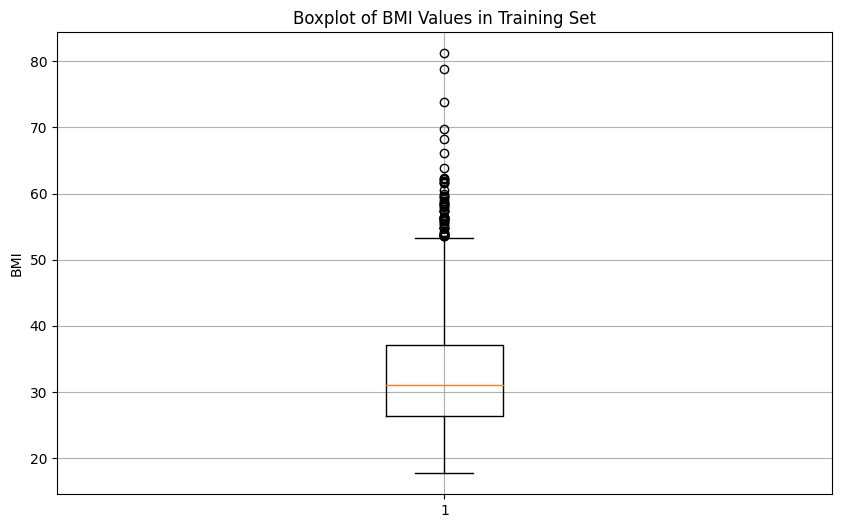

In [ ]:
plt.figure(figsize=(10, 6))  # You can adjust the size of the figure
plt.boxplot(train_labels)
plt.title('Boxplot of BMI Values in Training Set')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

In [ ]:
count_above_60 = np.sum(train_labels > 60)
print(f"Number of train labels above 60: {count_above_60}")


Number of train labels above 60: 15


In [ ]:
len(train_labels)

3210

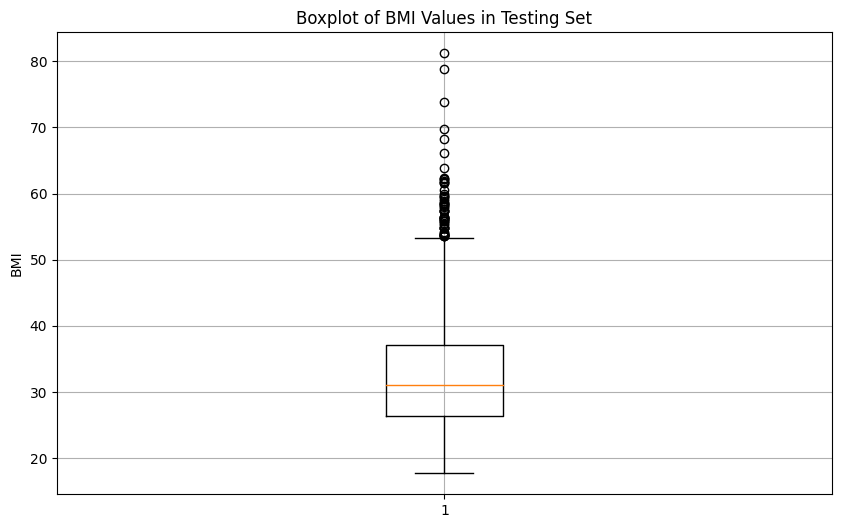

In [ ]:
plt.figure(figsize=(10, 6))  # You can adjust the size of the figure
plt.boxplot(train_labels)
plt.title('Boxplot of BMI Values in Testing Set')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

In [ ]:
count_above_60 = np.sum(test_labels > 60)
print(f"Number of labels above 60: {count_above_60}")


Number of labels above 60: 12


In [ ]:
# Print the first 5 rows where is_training is 1
print(data_cleaned[data_cleaned['is_training'] == 1].head(5))

   Unnamed: 0        bmi  gender  is_training       name
0           0  34.207396    Male            1  img_0.bmp
1           1  26.453720    Male            1  img_1.bmp
2           2  34.967561  Female            1  img_2.bmp
3           3  22.044766  Female            1  img_3.bmp
6           6  25.845588  Female            1  img_6.bmp


In [ ]:
print("Some testing labels:", test_labels[:5])


Some testing labels: [29.69849537 30.84591837 24.38979592 36.25867883 27.89129141]


In [ ]:
# Print the first 5 rows where is_training is 0
print(data_cleaned[data_cleaned['is_training'] == 0].head(5))

      Unnamed: 0        bmi  gender  is_training          name
3369        3369  29.698495    Male            0  img_3369.bmp
3370        3370  30.845918  Female            0  img_3370.bmp
3371        3371  24.389796  Female            0  img_3371.bmp
3372        3372  36.258679    Male            0  img_3372.bmp
3373        3373  27.891291    Male            0  img_3373.bmp


In [ ]:
# Getting the filenames and creating full paths for training images
train_image_filenames = train_rows['name'].tolist()
train_images = [os.path.join(image_path, filename) for filename in train_image_filenames]

# Getting the filenames and creating full paths for testing images
test_image_filenames = test_rows['name'].tolist()
test_images = [os.path.join(image_path, filename) for filename in test_image_filenames]

In [ ]:
len(train_images)

3210

In [ ]:
len(train_labels)

3210

In [ ]:
len(test_images)

752

In [ ]:
len(test_labels)

752

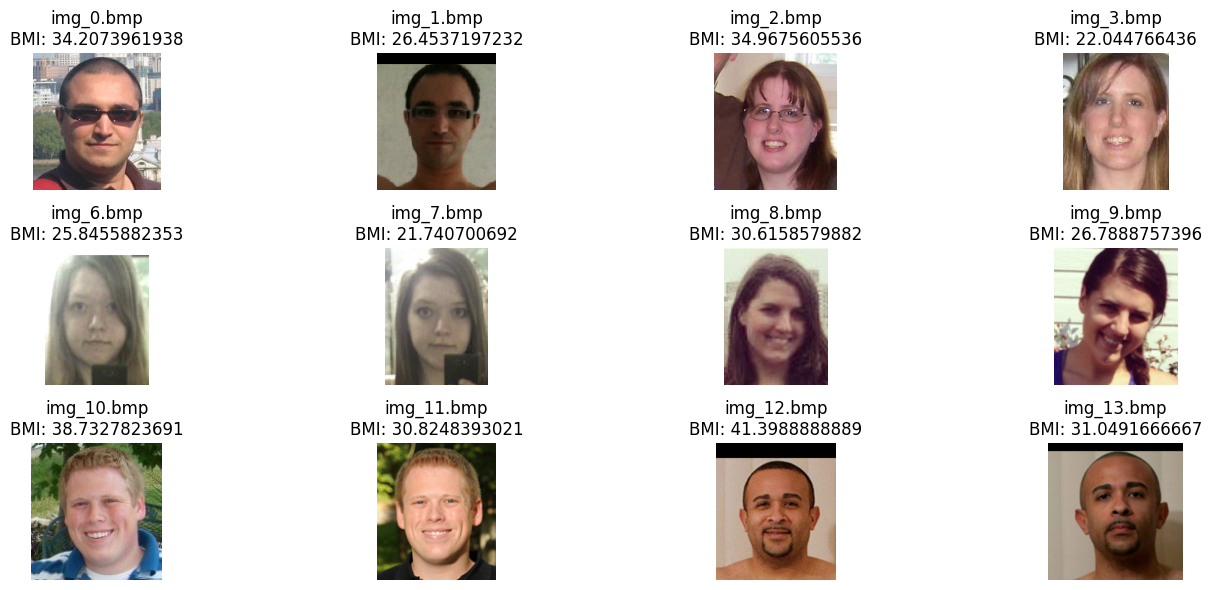

In [ ]:
# Assuming train_images and train_labels are already defined
num_images = 12
plt.figure(figsize=(15, 6))

for i in range(num_images):
    plt.subplot(3, 4, i + 1)  # Creating a grid of 3 rows and 4 columns
    img = Image.open(train_images[i])  # Load image
    plt.imshow(img)
    filename = os.path.basename(train_images[i])  # Extract filename from the path
    plt.title(f"{filename}\nBMI: {train_labels[i]}")
    plt.axis('off')  # Turn off axis numbers and labels

plt.tight_layout()
plt.show()


# Data Augmentation

In [ ]:
# Create a DataFrame for training and testing images and their labels
train_df = pd.DataFrame({'filename': train_images, 'label': train_labels})
test_df = pd.DataFrame({'filename': test_images, 'label': test_labels})

In [ ]:
filtered_train_df = train_df[train_df['label'] <= 60]
filtered_test_df = test_df[test_df['label'] <= 60]

Distribution of BMI Values in filtered Training and Testing Set

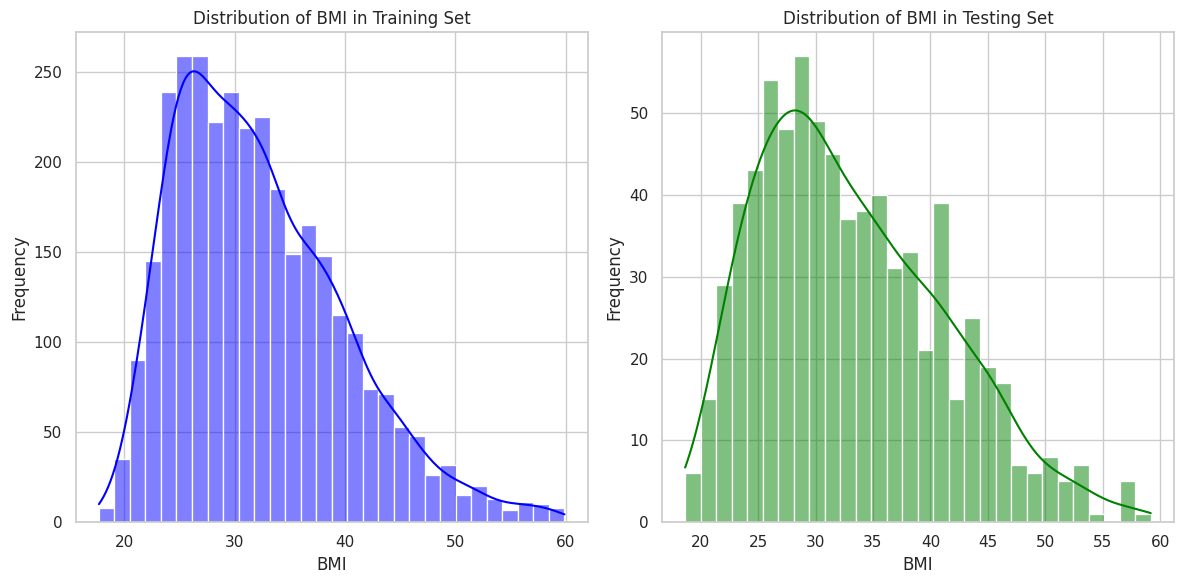

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot distribution for the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(filtered_train_df['label'], kde=True, color='blue', bins=30)
plt.title('Distribution of BMI in Training Set')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# Plot distribution for the testing set
plt.subplot(1, 2, 2)
sns.histplot(filtered_test_df['label'], kde=True, color='green', bins=30)
plt.title('Distribution of BMI in Testing Set')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
len(filtered_train_df)

3195

In [ ]:
len(filtered_test_df)

740

In [ ]:
batch_size = 16

# Define ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Define ImageDataGenerator for testing (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=filtered_train_df,
    x_col='filename',
    y_col='label',
    class_mode='raw',
    batch_size=batch_size,
    target_size=(224, 224)  # Adjust based on model's input size requirements
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=filtered_test_df,
    x_col='filename',
    y_col='label',
    class_mode='raw',
    batch_size=batch_size,
    target_size=(224, 224)
)

# Calculate steps_per_epoch for training
steps_per_epoch = len(filtered_train_df) // batch_size

Found 3195 validated image filenames.
Found 740 validated image filenames.


In [ ]:
# Get the first batch of images
train_images_batch, train_labels_batch = next(train_generator)
test_images_batch, test_labels_batch = next(test_generator)

# Check the shape of the first image in each batch
train_image_shape = train_images_batch[0].shape
test_image_shape = test_images_batch[0].shape

print("Shape of a training image:", train_image_shape)
print("Shape of a testing image:", test_image_shape)

Shape of a training image: (224, 224, 3)
Shape of a testing image: (224, 224, 3)


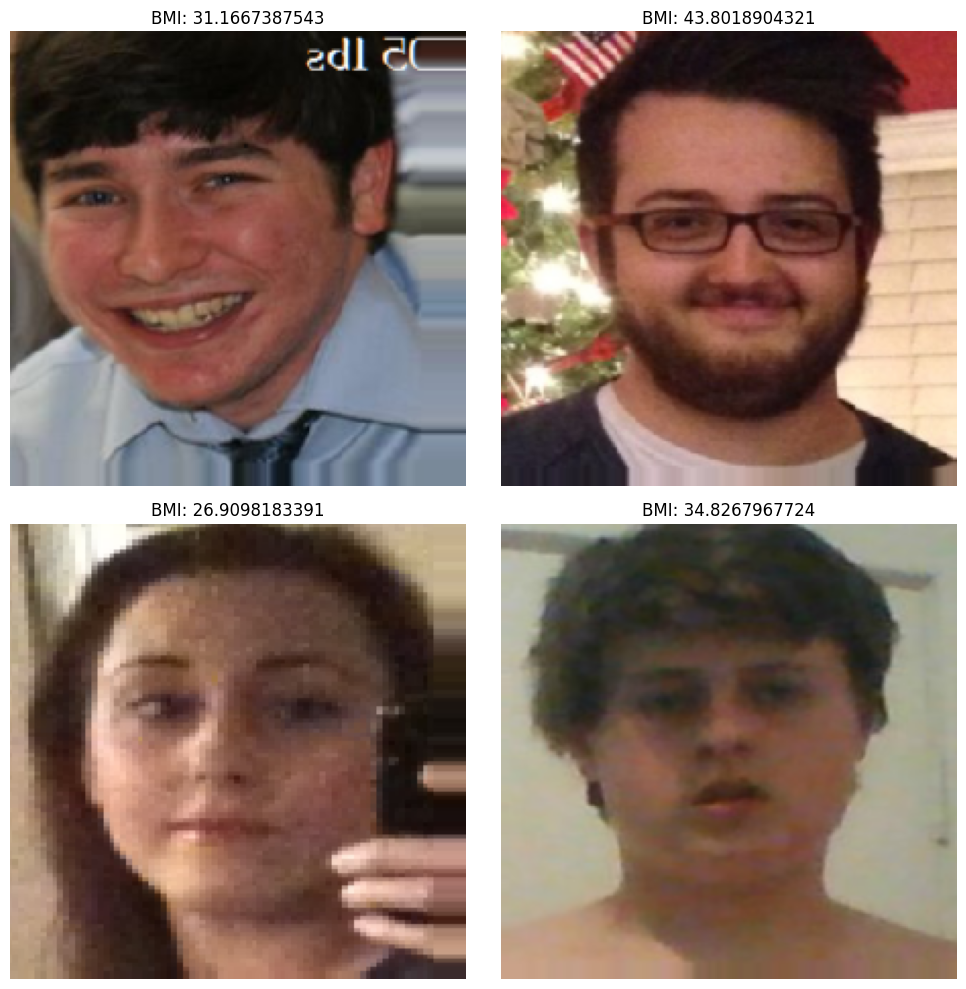

In [ ]:
# Number of images to display
num_images_to_display = 4

plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    # Plotting the resized images
    plt.subplot(2, 2, i + 1)
    image = train_images_batch[i]
    plt.imshow(image)
    plt.title(f"BMI: {train_labels_batch[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Modeling

Model 1 : Basic CNN Model

In [ ]:
CNN_model = models.Sequential()

# Convolutional Block 1
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))  # Adjust input_shape
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
CNN_model.add(layers.BatchNormalization())
# Pooling layer
CNN_model.add(layers.MaxPooling2D((2, 2)))
# Dropout layer
CNN_model.add(layers.Dropout(0.25))

# Convolutional Block 2
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dropout(0.25))

# Convolutional Block 3
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
CNN_model.add(layers.BatchNormalization())
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dropout(0.25))

# Flattening the convolutions
CNN_model.add(layers.Flatten())

# Fully Connected Layer
CNN_model.add(layers.Dense(128, activation='relu'))
CNN_model.add(layers.Dropout(0.25))

# Output layer for regression
CNN_model.add(layers.Dense(1, activation='linear'))  # Single neuron, linear activation

In [ ]:
pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.5 MB/s eta 0:00:00


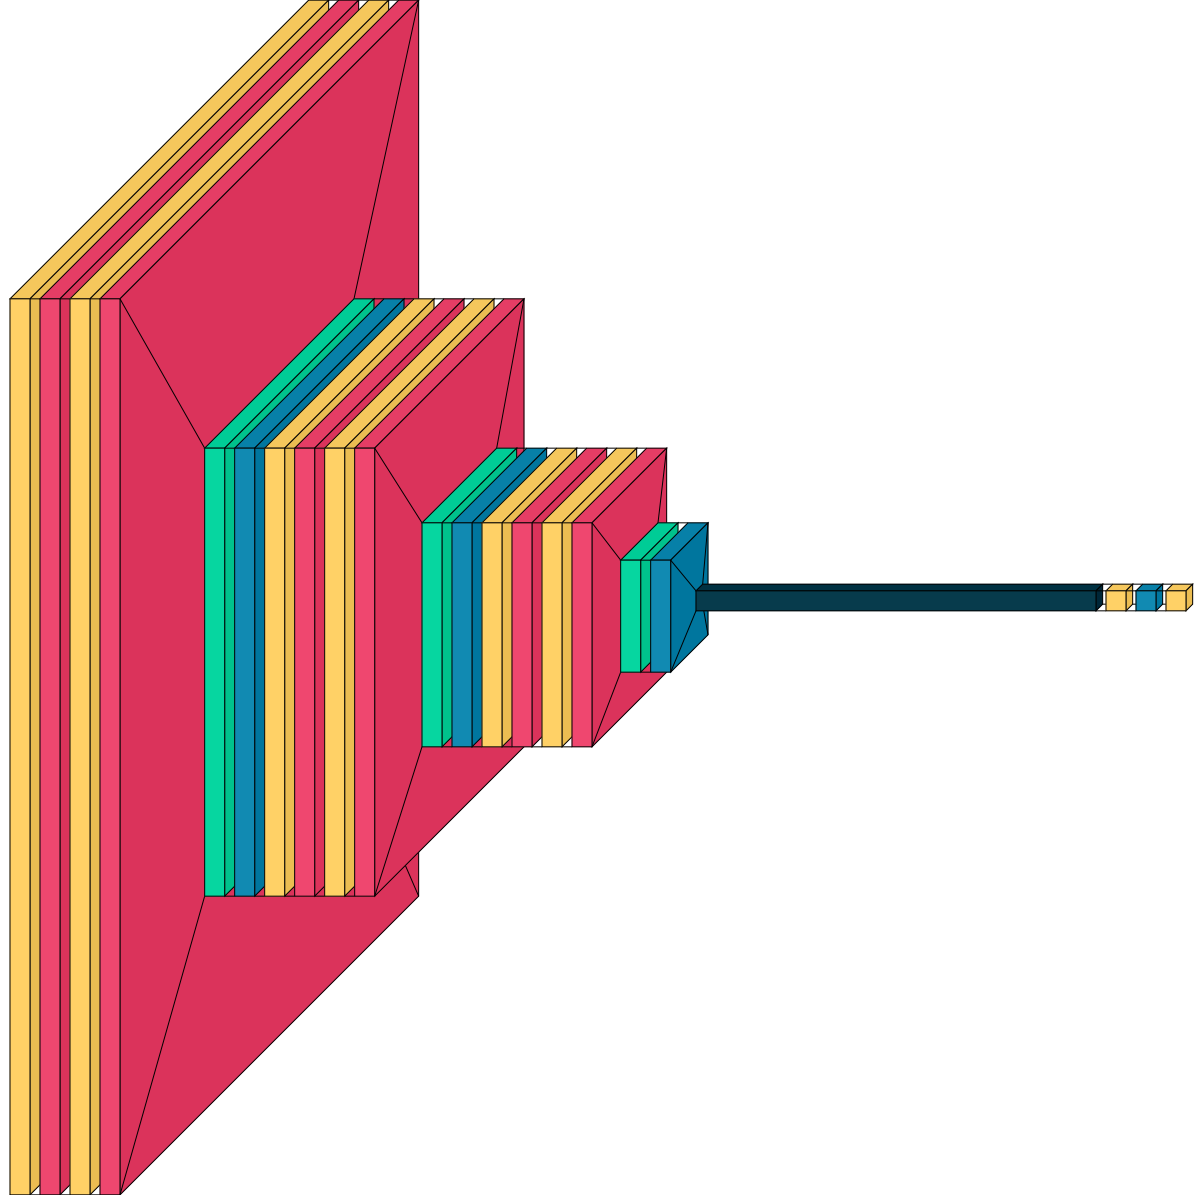

In [ ]:
import visualkeras
visualkeras.layered_view(CNN_model)

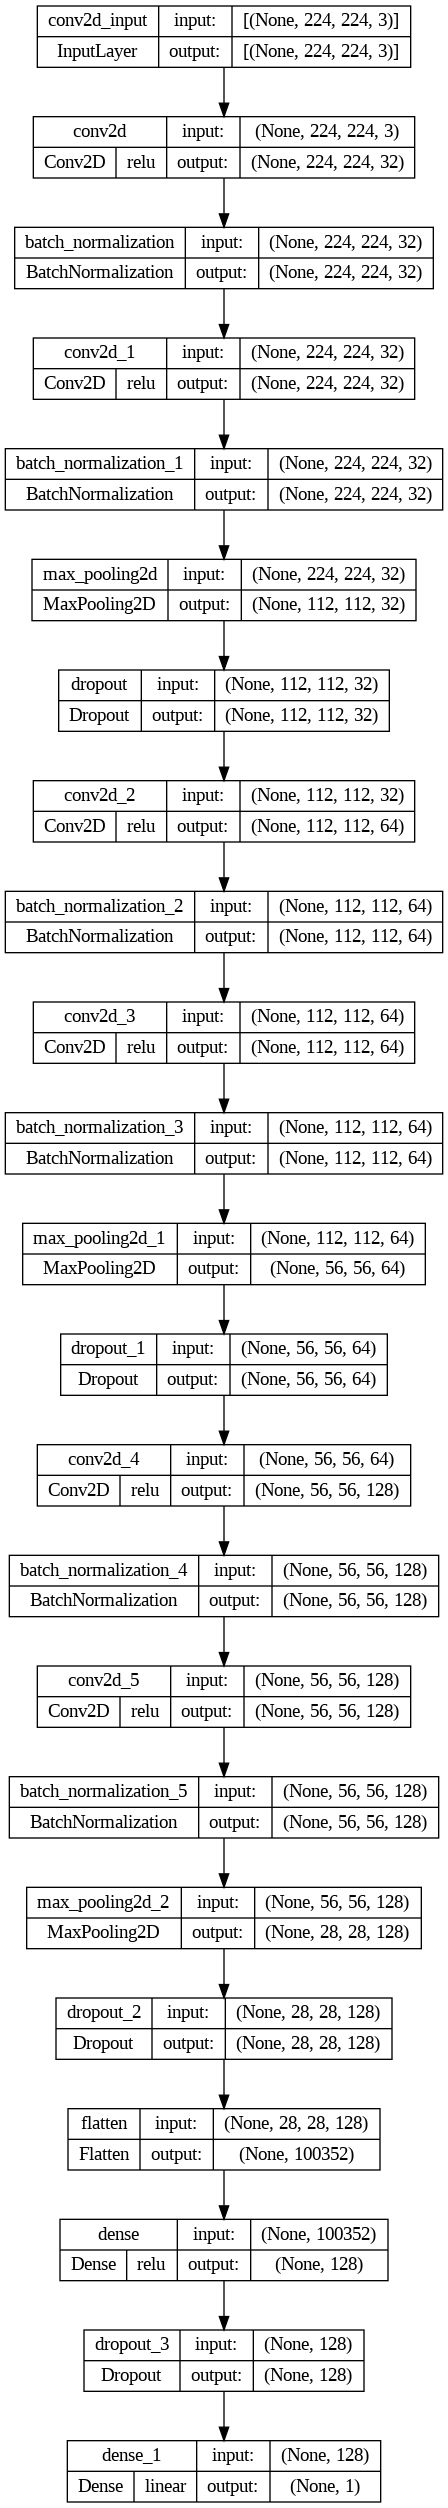

In [ ]:
tf.keras.utils.plot_model(
    CNN_model,
    to_file='CNN_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

# Training

In [ ]:
# Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Compile CNN Model
CNN_model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Mean Squared Error for regression tasks
    metrics=['mean_absolute_error']  # Mean Absolute Error as an additional metric
)

In [ ]:
# Train CNN

history_1 = CNN_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=test_generator,
    validation_steps=len(test_df) // batch_size,
    callbacks=[early_stopping_callback]  # Include the early stopping callback here
)

Epoch 1/100
200/200 [==============================] - 72s 307ms/step - loss: 1820.0970 - mean_absolute_error: 18.0422 - val_loss: 2347.6421 - val_mean_absolute_error: 46.4159
Epoch 2/100
200/200 [==============================] - 58s 290ms/step - loss: 188.8818 - mean_absolute_error: 10.7689 - val_loss: 325.6002 - val_mean_absolute_error: 15.1112
Epoch 3/100
200/200 [==============================] - 60s 299ms/step - loss: 166.0189 - mean_absolute_error: 10.1889 - val_loss: 338.7155 - val_mean_absolute_error: 15.3287
Epoch 4/100
200/200 [==============================] - 60s 299ms/step - loss: 163.1629 - mean_absolute_error: 10.1266 - val_loss: 209.8887 - val_mean_absolute_error: 11.3299
Epoch 5/100
200/200 [==============================] - 60s 302ms/step - loss: 151.0387 - mean_absolute_error: 9.6282 - val_loss: 166.8305 - val_mean_absolute_error: 9.8068
Epoch 6/100
200/200 [==============================] - 59s 292ms/step - loss: 154.3052 - mean_absolute_error: 9.7005 - val_loss: 1

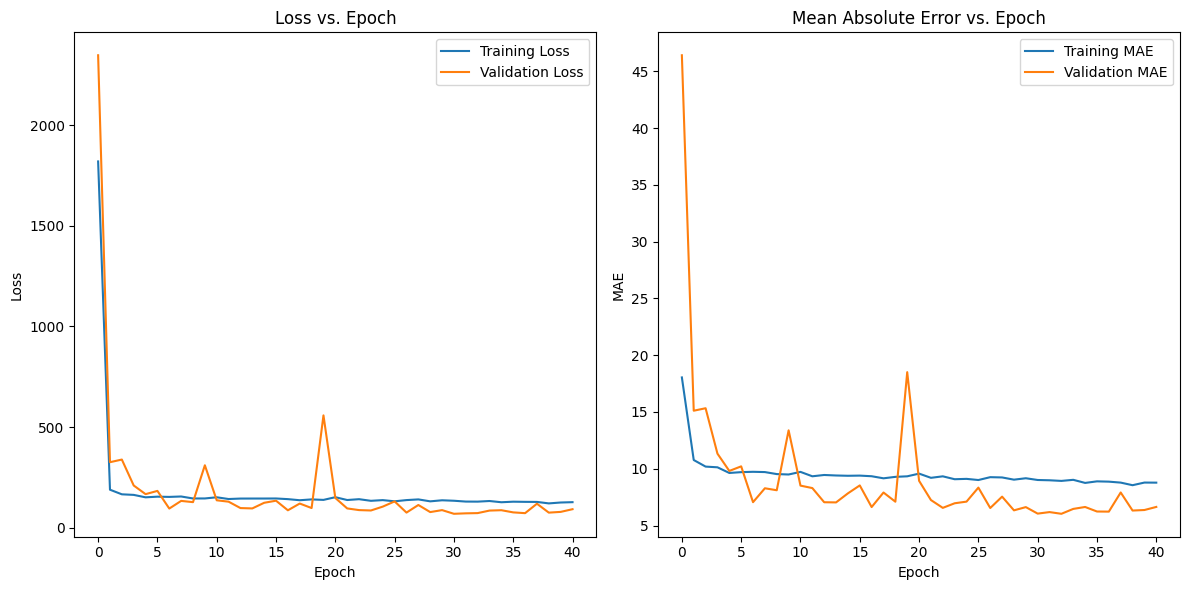

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MSE
plt.subplot(1, 2, 2)
plt.plot(history_1.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_1.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


Model 2 : ViT Model

In [ ]:
model_name = "vit-b8"
model_handle_map = {
    "vit-b8": "https://tfhub.dev/sayakpaul/vit_b8_fe/1",
}
model_handle = model_handle_map[model_name]

In [ ]:
IMAGE_SIZE = (224, 224)
do_fine_tuning = False  # Set to True if you want to fine-tune the base model

print("Building model with", model_handle)
vit_bmi_model_new = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for BMI prediction
])

Building model with https://tfhub.dev/sayakpaul/vit_b8_fe/1


In [ ]:
visualkeras.layered_view(vit_bmi_model_new)

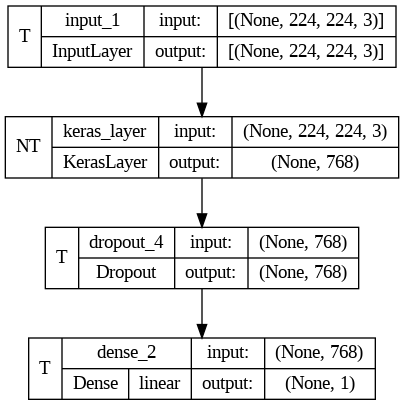

In [ ]:
tf.keras.utils.plot_model(
    vit_bmi_model_new,
    to_file='vit_bmi_model_new.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
vit_bmi_model_new.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [ ]:
history3 = vit_bmi_model_new.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=len(filtered_test_df) // batch_size,
    callbacks=[early_stopping_callback]
)

Epoch 1/10
199/199 [==============================] - 2192s 11s/step - loss: 67.2699 - mean_absolute_error: 6.3928 - val_loss: 53.6966 - val_mean_absolute_error: 5.6149
Epoch 2/10
199/199 [==============================] - 197s 992ms/step - loss: 51.6240 - mean_absolute_error: 5.6262 - val_loss: 54.1198 - val_mean_absolute_error: 5.5988
Epoch 3/10
199/199 [==============================] - 200s 1s/step - loss: 48.3295 - mean_absolute_error: 5.4941 - val_loss: 51.7460 - val_mean_absolute_error: 5.5031
Epoch 4/10
199/199 [==============================] - 204s 1s/step - loss: 49.0704 - mean_absolute_error: 5.5116 - val_loss: 49.7362 - val_mean_absolute_error: 5.4383
Epoch 5/10
199/199 [==============================] - 204s 1s/step - loss: 48.9204 - mean_absolute_error: 5.5171 - val_loss: 50.8783 - val_mean_absolute_error: 5.5773
Epoch 6/10
199/199 [==============================] - 200s 1s/step - loss: 48.9523 - mean_absolute_error: 5.4745 - val_loss: 52.2653 - val_mean_absolute_error: 

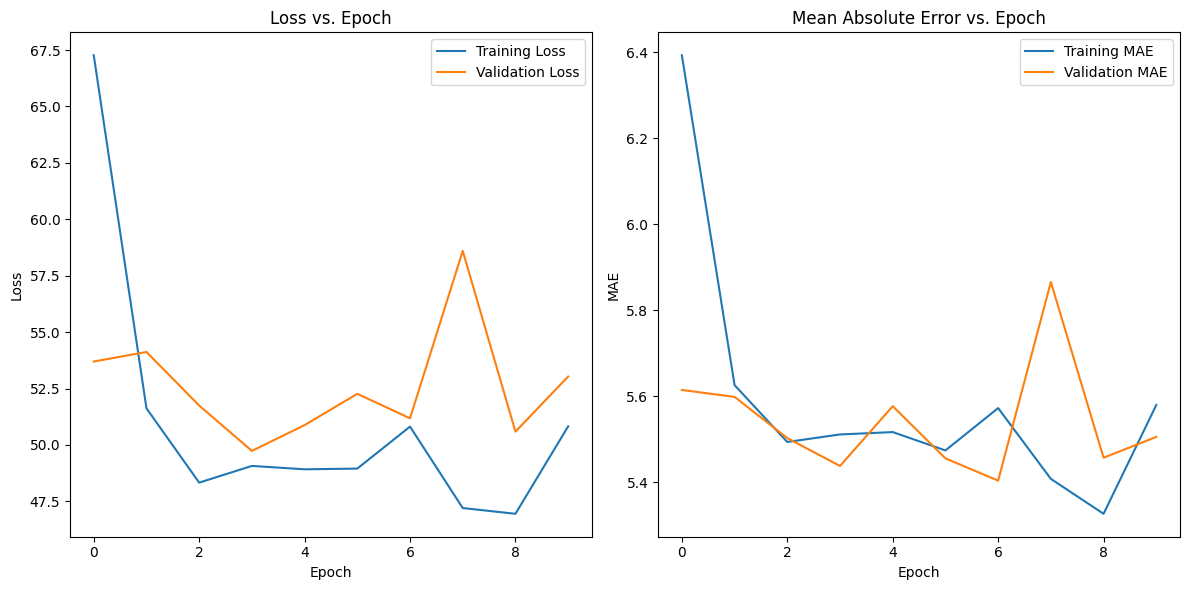

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MSE
plt.subplot(1, 2, 2)
plt.plot(history3.history['mean_absolute_error'], label='Training MAE')
plt.plot(history3.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation - CNN Model

In [ ]:
# Evaluate the model on the testing set with verbose output
test_loss, test_mae = CNN_model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

47/47 [==============================] - 4s 85ms/step - loss: 69.2046 - mean_absolute_error: 6.0481
Test Loss: 69.2046
Test MAE: 6.0481


In [ ]:
# Save the model to a file
CNN_model.save("/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/CNN_BMI_model.h5")

In [ ]:
# Save the model in native Keras format
CNN_model.save("/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/CNN_BMI_model.keras")

47/47 [==============================] - 3s 57ms/step


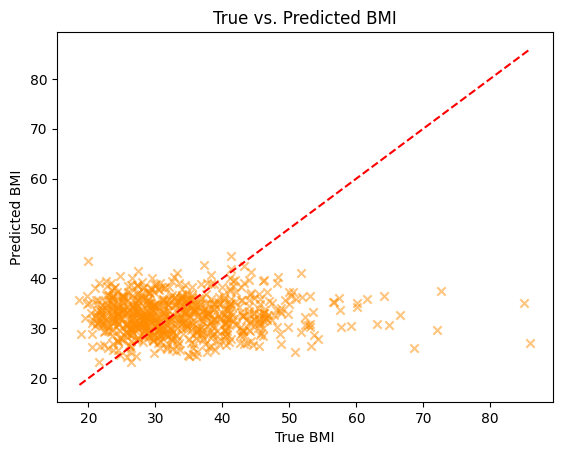

In [ ]:
test_predictions = CNN_model.predict(test_generator)

# Create a scatter plot
plt.scatter(test_labels, test_predictions, alpha=0.5, c='darkorange', label='Predicted BMI', marker = 'x')
plt.xlabel("True BMI")
plt.ylabel("Predicted BMI")
plt.title("True vs. Predicted BMI")

# Add a diagonal line for reference
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], linestyle='--', color='red')

plt.show()

# Evaluation - ViT

In [ ]:
# Evaluate the model on the testing set with verbose output
VIT_test_loss, VIT_test_mae = vit_bmi_model_new.evaluate(test_generator, verbose=1)

print(f"Test Loss: {VIT_test_loss:.4f}")
print(f"Test MAE: {VIT_test_mae:.4f}")

47/47 [==============================] - 41s 858ms/step - loss: 52.7675 - mean_absolute_error: 5.4860
Test Loss: 52.7675
Test MAE: 5.4860


In [ ]:
filtered_test_labels = filtered_test_df['label'].values

In [ ]:
len(filtered_test_labels)

740

47/47 [==============================] - 37s 803ms/step


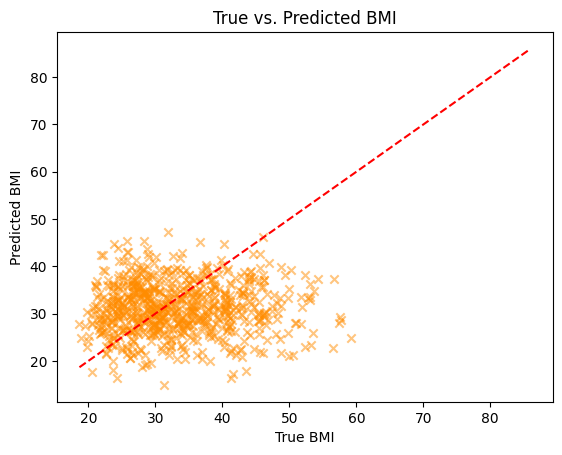

In [ ]:
VIT_test_predictions = vit_bmi_model_new.predict(test_generator)

# Create a scatter plot
plt.scatter(filtered_test_labels, VIT_test_predictions, alpha=0.5, c='darkorange', label='Predicted BMI', marker = 'x')
plt.xlabel("True BMI")
plt.ylabel("Predicted BMI")
plt.title("True vs. Predicted BMI")

# Add a diagonal line for reference
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], linestyle='--', color='red')

plt.show()

In [ ]:
# Save the model to a file
vit_bmi_model_new.save("/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/ViT_BMI_model")

In [ ]:
vit_bmi_model_new.save("/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/ViT_BMI_model.keras")

# Predictions

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/ViT_BMI_model.keras"
loaded_vit_model = load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
model_path_3 = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/CNN_BMI_model.h5"
loaded_CNN = load_model(model_path_3)

ViT Predictions

1/1 [==============================] - 10s 10s/step


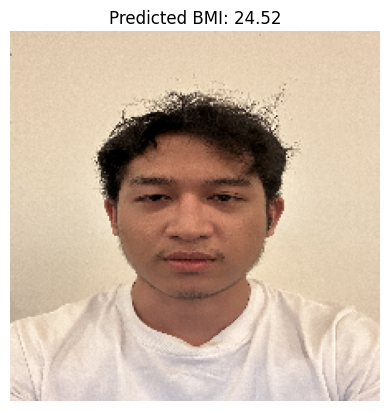

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test image alfi.JPG"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 35ms/step


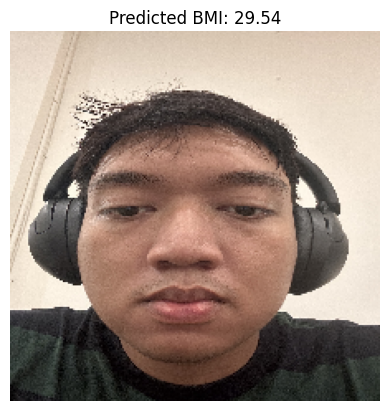

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic rafi.JPG"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 36ms/step


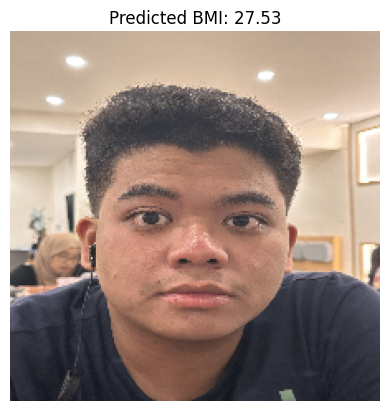

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic naufal.jpg"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 36ms/step


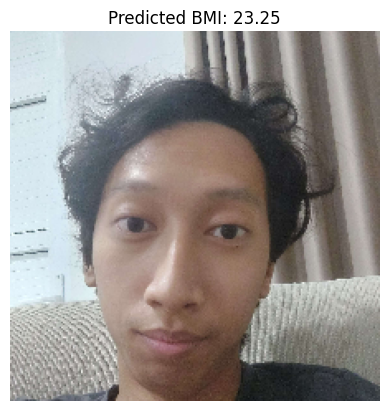

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic rifki square.jpg"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 25ms/step


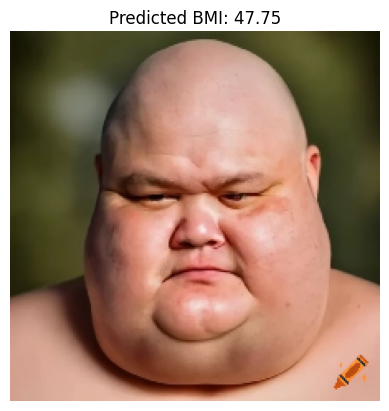

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/fat egg head test pic.png"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 11s 11s/step


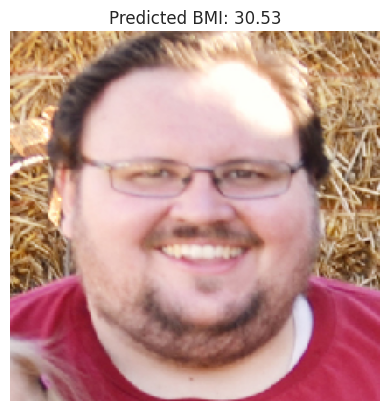

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = filtered_test_df.loc[index_to_predict, 'filename']
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_vit_model.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

CNN Predictions

1/1 [==============================] - 0s 292ms/step


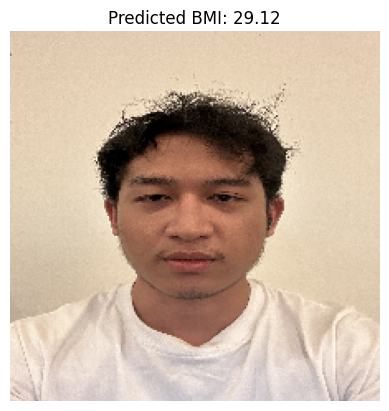

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test image alfi.JPG"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_CNN.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 481ms/step


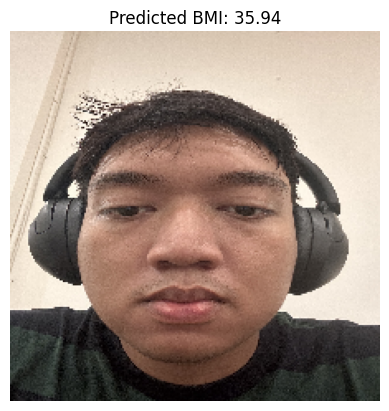

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic rafi.JPG"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_CNN.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 185ms/step


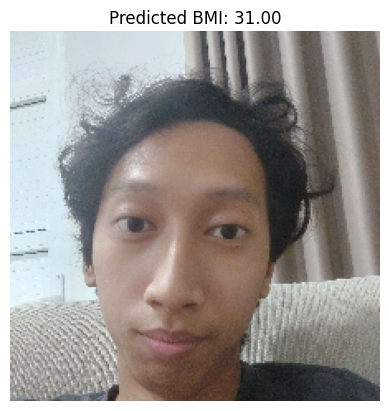

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic rifki square.jpg"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_CNN.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 115ms/step


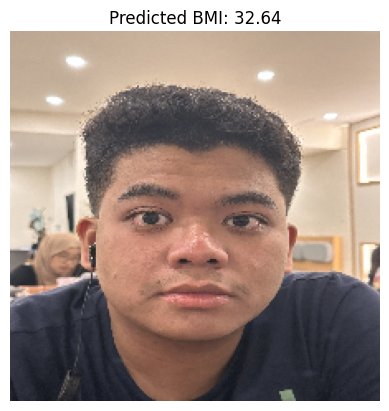

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the image pixels
    img_array = img_array / 255.0
    # Expand dimensions to match the model's input format
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace with the path to your input image
image_path = "/content/drive/MyDrive/UNI/Semester 5/DL/Final Project/test pic naufal.jpg"
input_image = preprocess_image(image_path, target_size=(224, 224))  # Adjust size to match your model's input
predicted_bmi = loaded_CNN.predict(input_image)
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Predicted BMI: {predicted_bmi[0][0]:.2f}")
plt.axis('off')
plt.show()